In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False

Simulated binary star

In [3]:
import numpy as np
from isochrones import get_ichrone
from isochrones.utils import addmags

distance = 500  # pc
AV = 0.2
mass_A = 1.0
mass_B = 0.5
age = 9.6
feh = 0.0

# Synthetic 2MASS and Gaia magnitudes
bands = ['J', 'H', 'K', 'BP', 'RP', 'G']
mist = get_ichrone('mist')
data_A = mist.track.generate(mass_A, age, feh, distance=distance, AV=AV, bands=bands, return_dict=True, accurate=True)
data_B = mist.track.generate(mass_B, age, feh, distance=distance, AV=AV, bands=bands, return_dict=True, accurate=True)

# Test uncertainties
unc = dict(J=0.02, H=0.02, K=0.02, BP=0.002, RP=0.002, G=0.001)

# This is the offest introduced by the noise
np.random.seed(546)
eps = {b: unc[b] * np.random.randn() for b in unc}

# Simulated Gaia parallax
parallax = (1000 / distance + 0.05 * np.random.randn(), 0.05)

# Observations if we had just seen A
mags_A = {b: (data_A[b + "_mag"], unc[b]) for b in unc}

# Observations if we have unresolved binary
mags_tot = {b: (addmags(data_A[b + "_mag"], data_B[b + "_mag"]), unc[b]) for b in unc}

Holoviews not imported. Some visualizations will not be available.


Make sure that single star fit works. Here we're fitting a single star model to the "data" for just star A so everything should work.

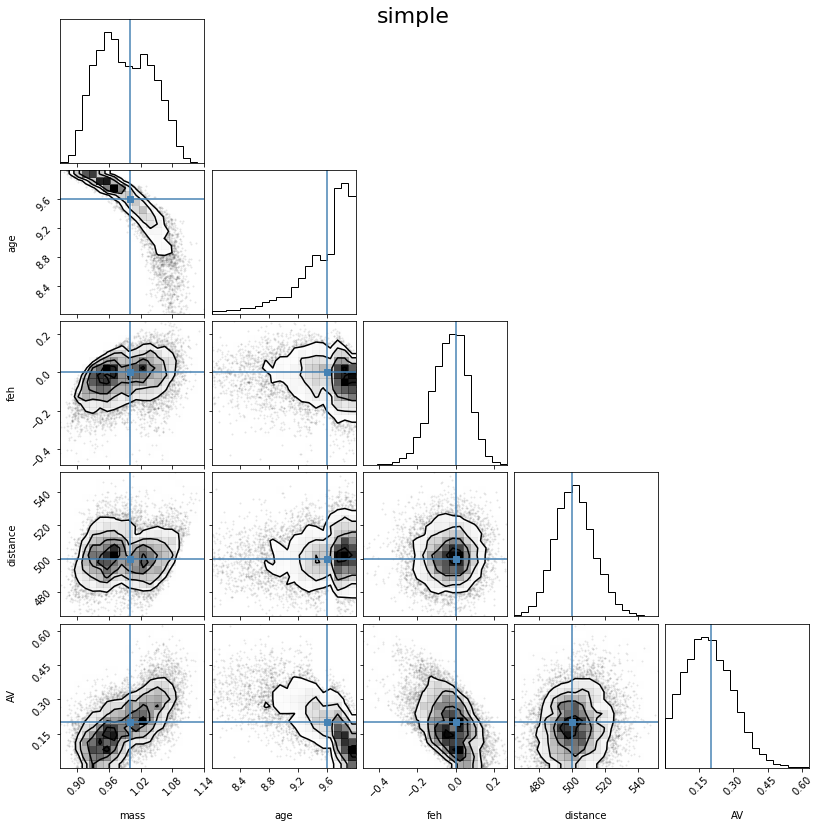

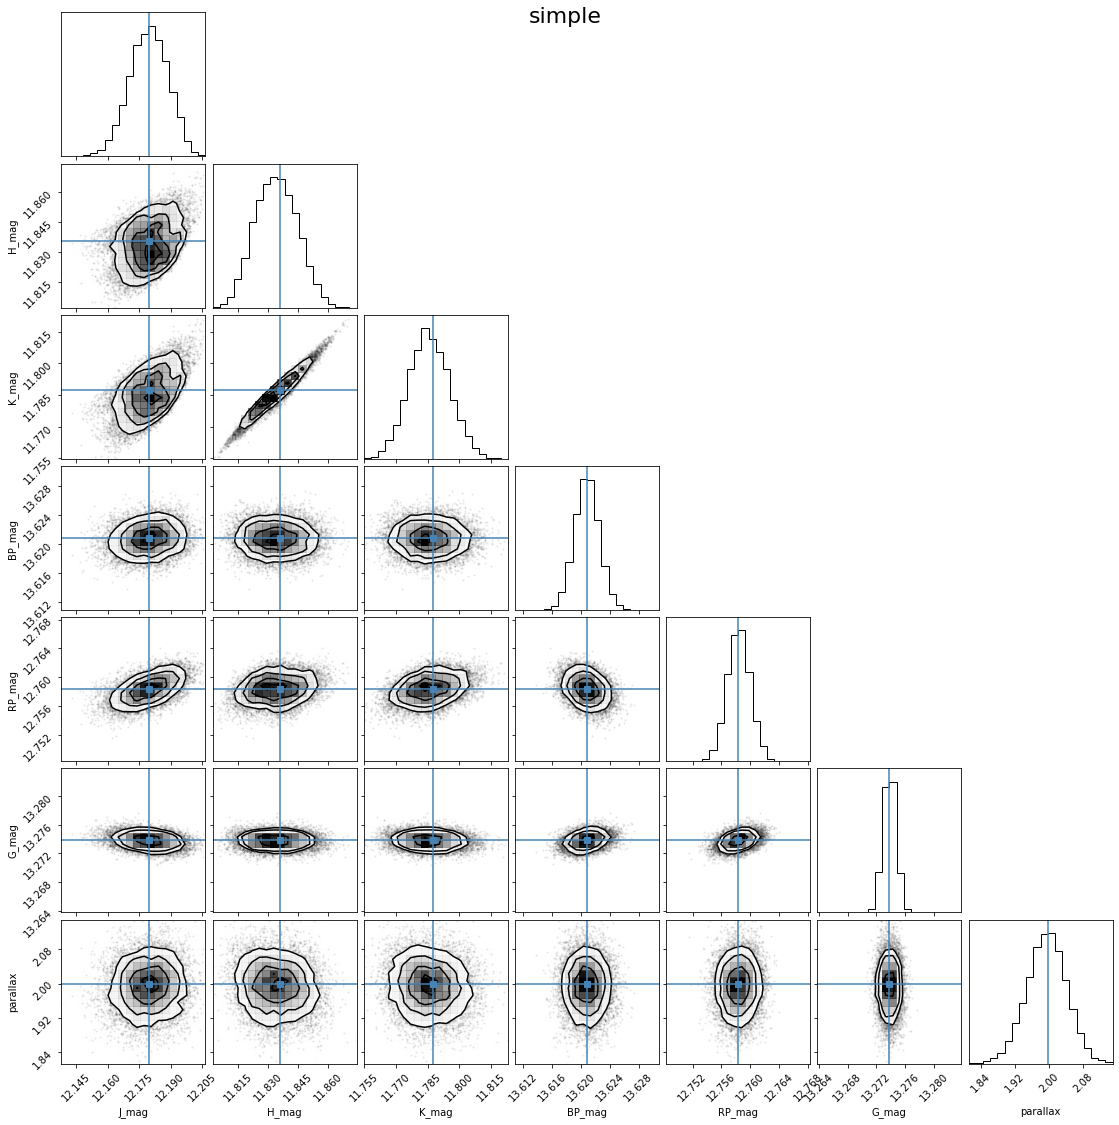

In [4]:
from isochrones import SingleStarModel

mod_simple = SingleStarModel(mist, **mags_A, parallax=parallax, name="simple")
mod_simple.set_bounds(eep=(1, 600), age=(8, 10))
mod_simple.fit(n_live_points=2000)

columns = ['mass', 'age', 'feh', 'distance', 'AV']
truths = [mass_A, age, feh, distance, AV]
mod_simple.corner_derived(columns, truths=truths)

mod_simple.corner_observed();

Now fit total magnitude using single star model. Here we're fitting a single star model to the magnitude of star A + star B, so this is a *wrong* model. What happens here?

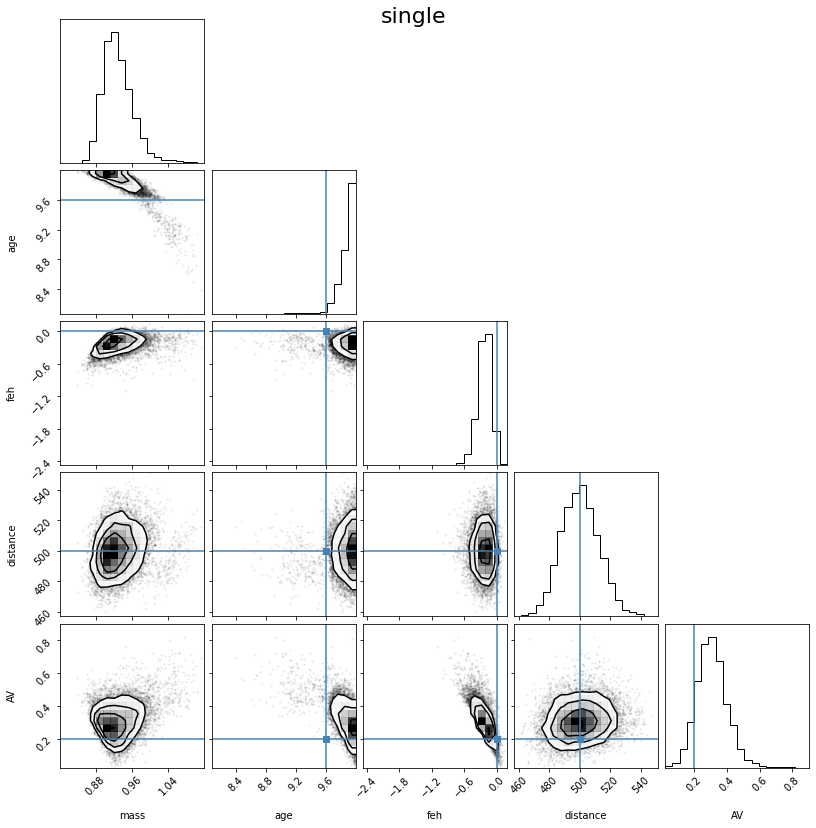

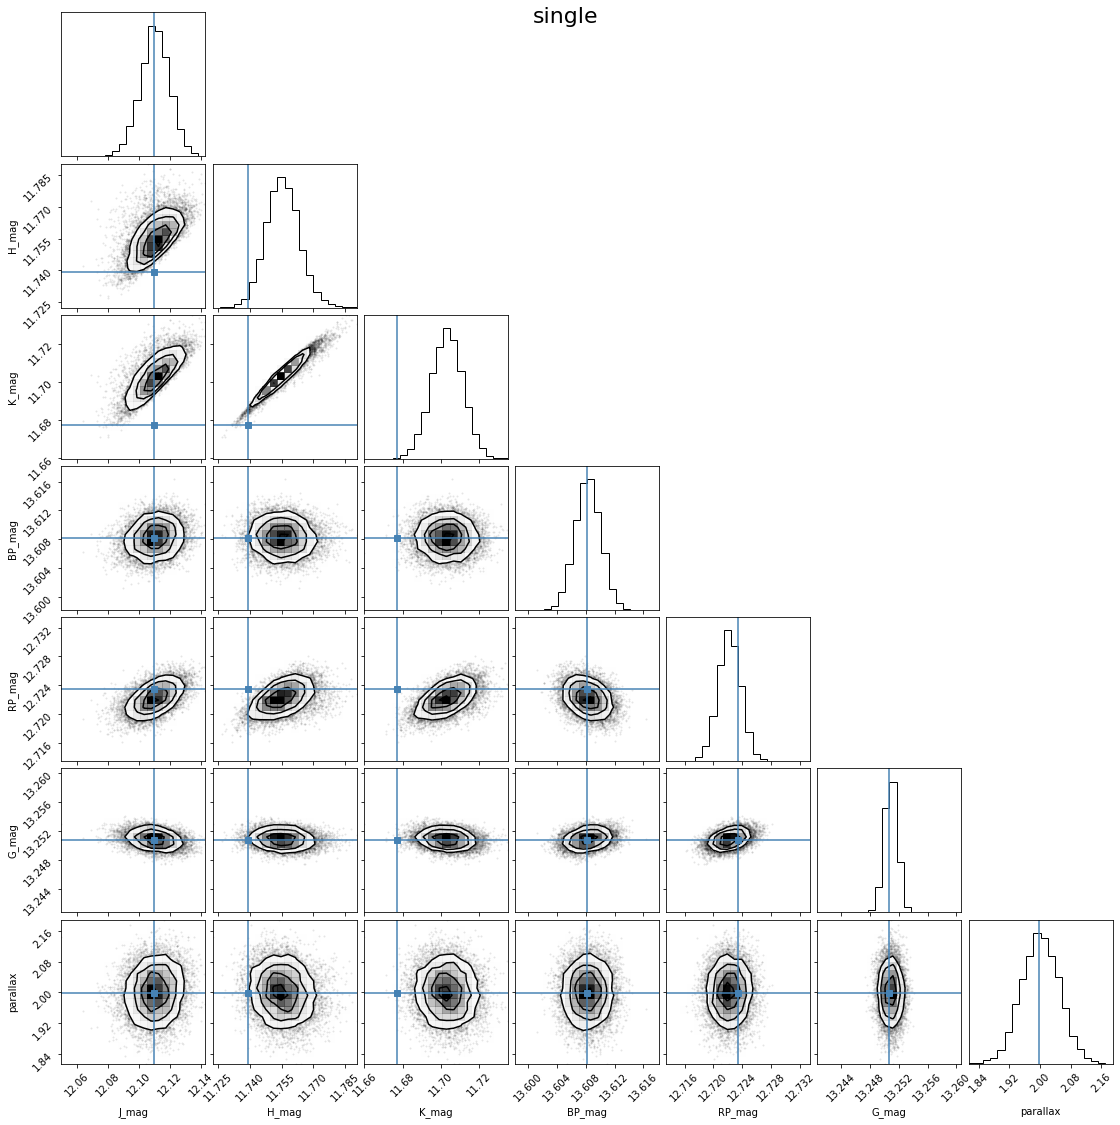

In [5]:
mod_single = SingleStarModel(mist, **mags_tot, parallax=parallax, name="single")
mod_single.set_bounds(eep=(1, 600), age=(8, 10))
mod_single.fit(n_live_points=2000)

columns = ['mass', 'age', 'feh', 'distance', 'AV']
truths = [None, age, feh, distance, AV]
mod_single.corner_derived(columns, truths=truths)

mod_single.corner_observed();

Finally fit as a binary. Here we're fitting the correct model to the simulated binary data. Everything should work...

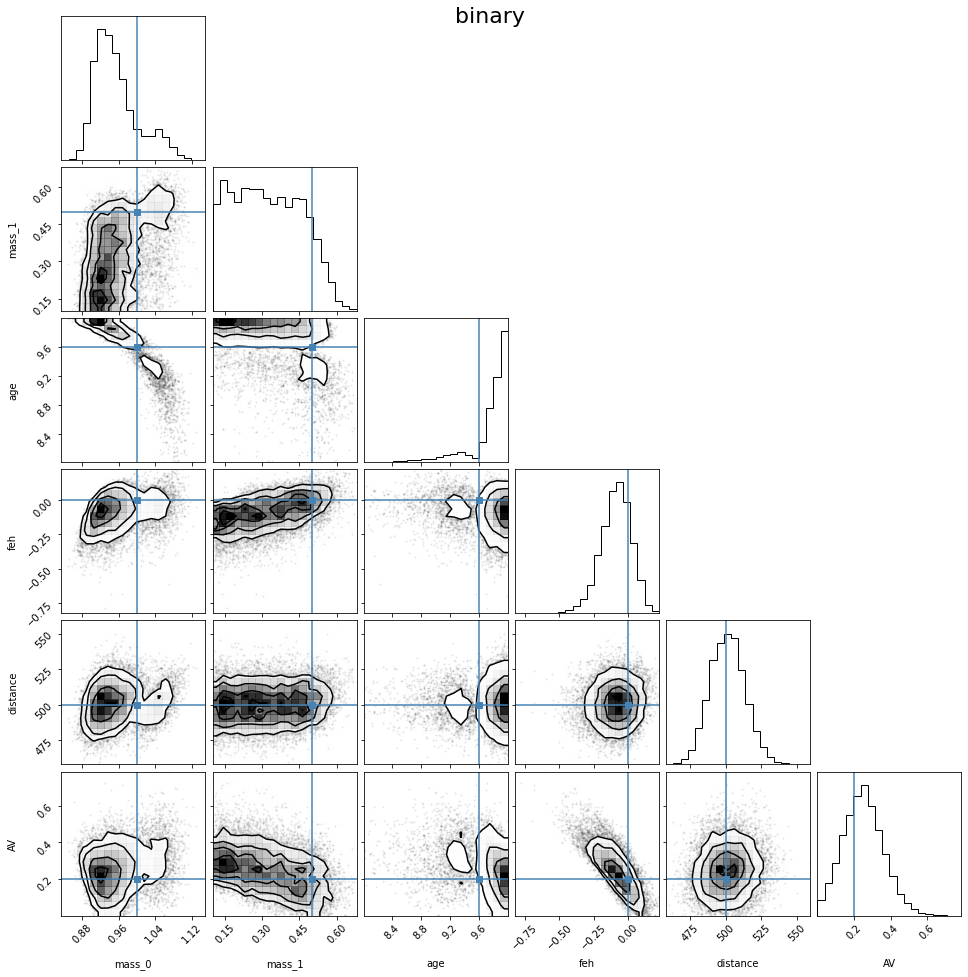

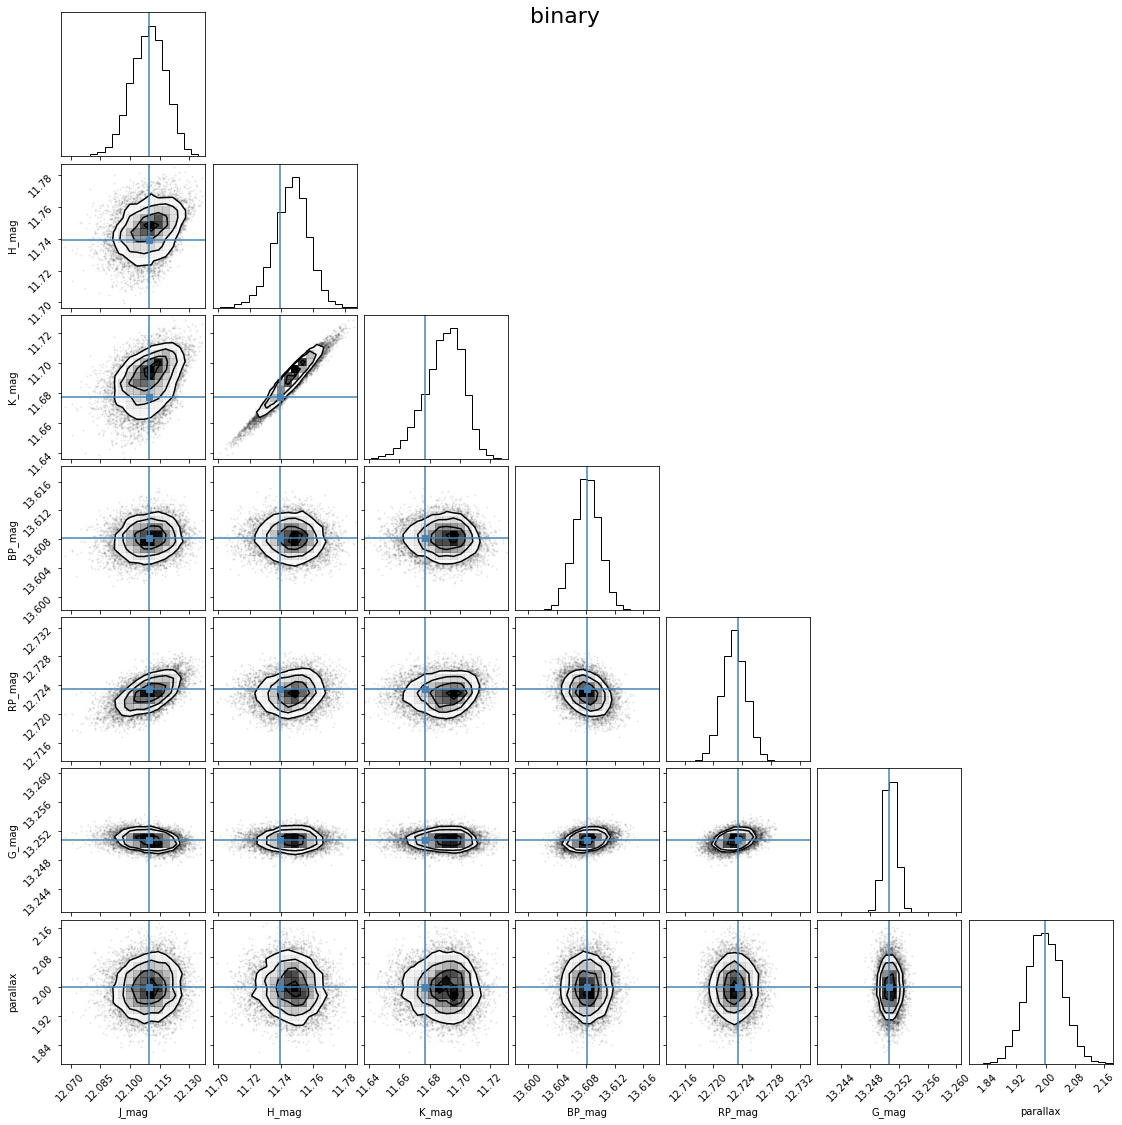

In [6]:
from isochrones import BinaryStarModel

mod_binary = BinaryStarModel(mist, **mags_tot, parallax=parallax, name="binary")
mod_binary.set_bounds(eep=(1, 600), age=(8, 10))
mod_binary.fit(n_live_points=2000)

columns = ['mass_0', 'mass_1', 'age', 'feh', 'distance', 'AV']
truths = [mass_A, mass_B, age, feh, distance, AV]
mod_binary.corner_derived(columns, truths=truths)

mod_binary.corner_observed();

Finally, fit a binary star model to just the magnitudes from A (this should be just a single star, what do we get for the masses?)

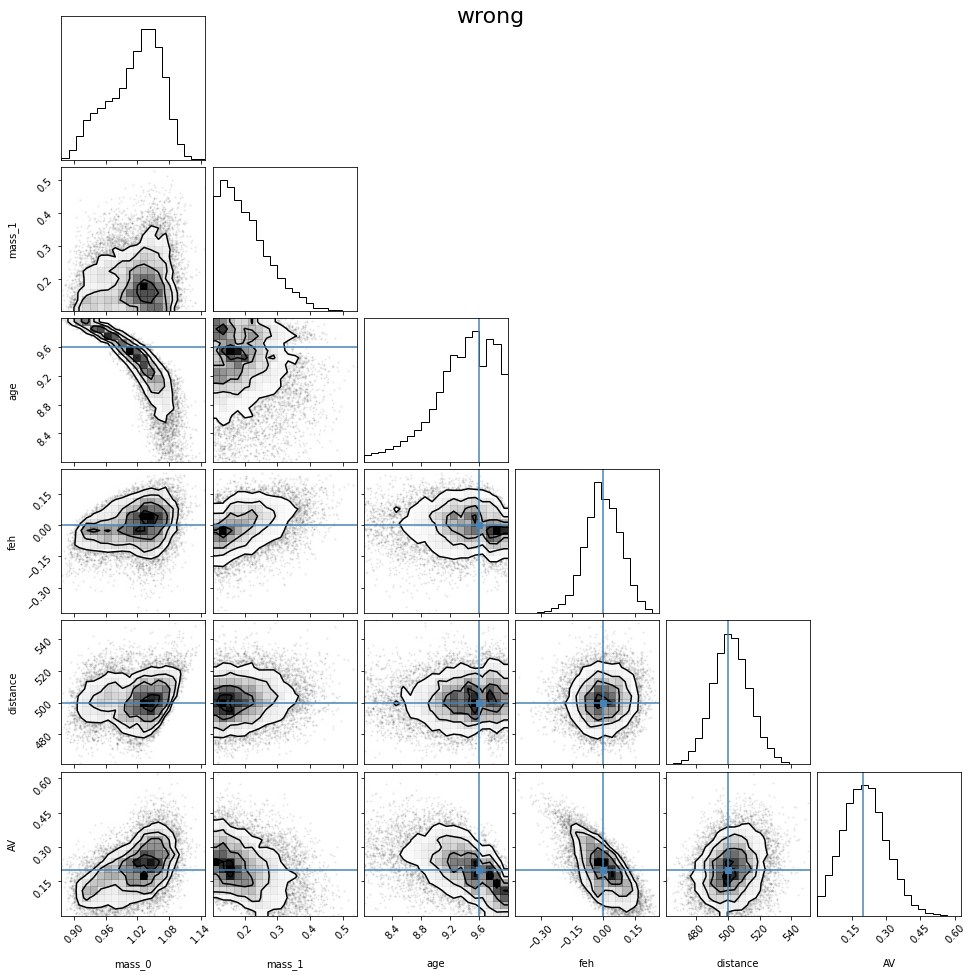

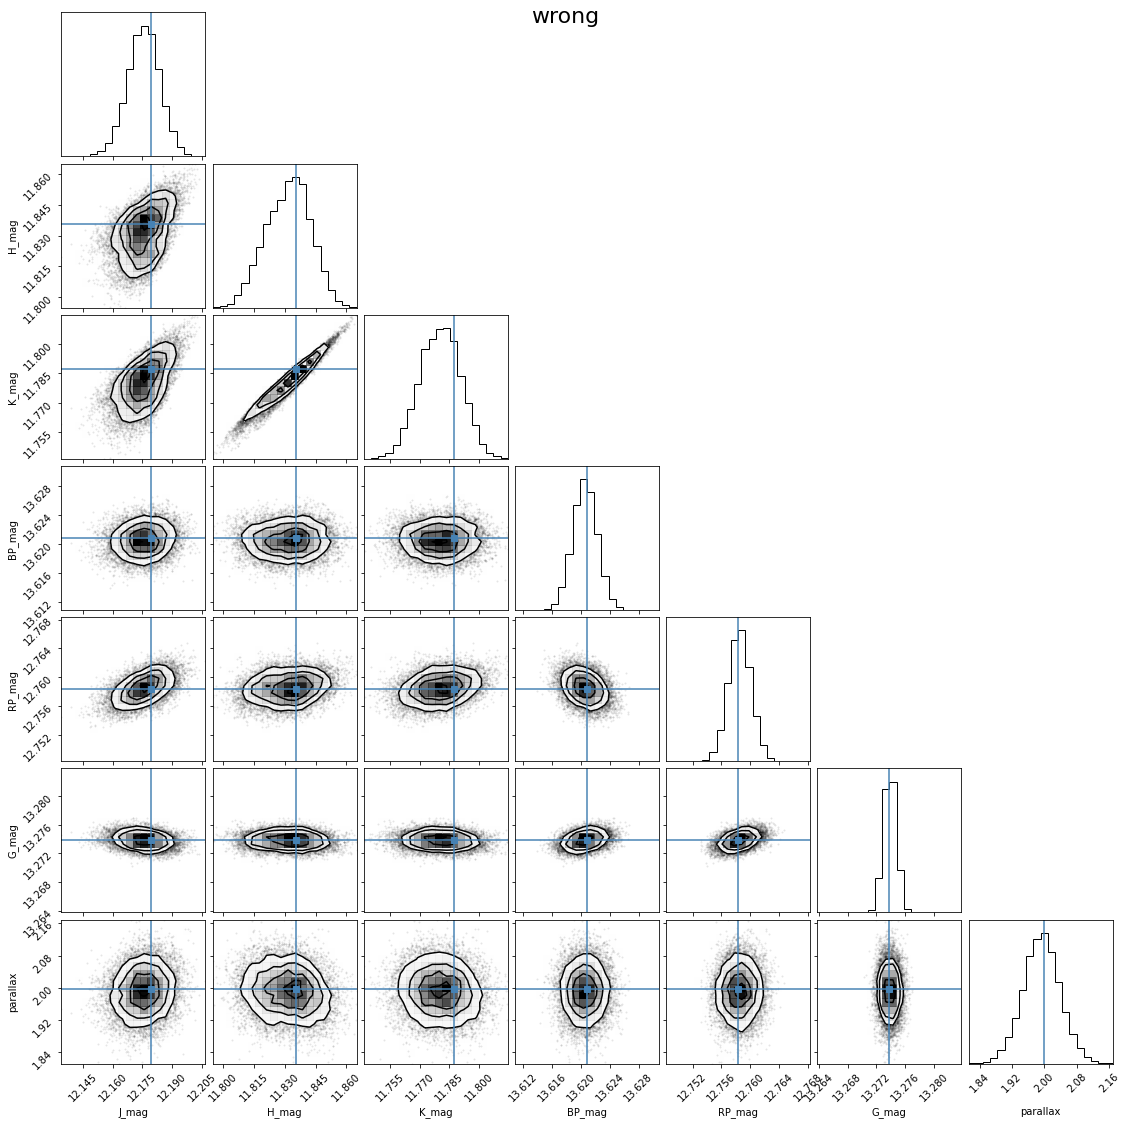

In [7]:
mod_wrong = BinaryStarModel(mist, **mags_A, parallax=parallax, name="wrong")
mod_wrong.set_bounds(eep=(1, 600), age=(8, 10))
mod_wrong.fit(n_live_points=2000)

columns = ['mass_0', 'mass_1', 'age', 'feh', 'distance', 'AV']
truths = [None, None, age, feh, distance, AV]
mod_wrong.corner_derived(columns, truths=truths)

mod_wrong.corner_observed();

In [12]:
np.percentile(mod_wrong._derived_samples["mass_1"] / mod_wrong._derived_samples["mass_0"], 90)

0.29955683548525314

The mass ratio is less than 0.3 at 90% "confidence". The details of this statement probably need some work. Perhaps this is promising!